### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [17]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here

data.isna().sum()

vendor_id                  0
passenger_count       145864
store_and_fwd_flag         0
distance_km           145864
log_trip_duration          0
anomaly                    0
traffic_jam                0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
hour_1                     0
hour_2                     0
hour_3                     0
hour_4                     0
hour_5                     0
hour_6                     0
hour_7                     0
hour_8                     0
hour_9                     0
hour_10                    0
hour_11                    0
hour_12                    0
hour_13                    0
hour_14                    0
hour_15                    0
hour_16                    0
hour_17                    0
hour_18                    0
hour_19                    0
hour_20                    0
hour_21                    0
hour_22       

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [31]:
### Your code is here

data['passenger_count'] = data['passenger_count'].fillna(data['passenger_count'].value_counts().index[0])

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [36]:
### Your code is here
grouped_means = data.groupby(['vendor_id','store_and_fwd_flag','traffic_jam','month_2','month_3',
    'month_4','month_5','month_6'])['distance_km'].transform('mean')

In [37]:
### Убедимся, что пропусков не осталось

### Your code is here

data['distance_km'] = data['distance_km'].fillna(grouped_means)

In [38]:
data.head(20).to_csv('ans1.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [40]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here

X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']


losses_test = []
losses_train = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    # На каждой итерации строим лин.регрессию на train
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Замеряем качество модели(RMSE)
    losses_test.append(np.mean((model.predict(X_test)-Y_test)**2))
    losses_train.append(np.mean((model.predict(X_train)-Y_train)**2))

#losses_test.append(np.mean((model.predict(X)-y)**2))

print(f"MSLE на Кросс-валидации: {round(np.mean(losses_train), 3)}")

MSLE на Кросс-валидации: 0.43


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

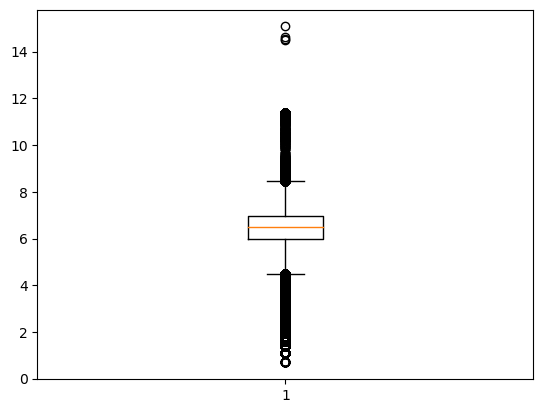

In [42]:
import matplotlib.pyplot as plt

### Your code is here
x = plt.boxplot(data['log_trip_duration'])

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [79]:
### Your code is here
high = data['log_trip_duration'].quantile(0.995)
low = data['log_trip_duration'].quantile(0.005)

r = high - low

In [80]:
get_low = low - r
get_high = high + r

In [84]:
df = data[(data['log_trip_duration'] > low) & (data['log_trip_duration'] < high)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [85]:
### Your code is here

from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here

X = df.drop('log_trip_duration', axis=1)
y = df['log_trip_duration']


losses_test = []
losses_train = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    # На каждой итерации строим лин.регрессию на train
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Замеряем качество модели(RMSE)
    losses_test.append(np.mean((model.predict(X_test)-Y_test)**2))
    losses_train.append(np.mean((model.predict(X_train)-Y_train)**2))

#losses_test.append(np.mean((model.predict(X)-y)**2))

model_1 = LinearRegression()
cv_result = cross_validate(model_1, X, y, 
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

print(f"MSLE на Кросс-валидации: {round(np.mean(losses_test), 4)}")

cv_result


MSLE на Кросс-валидации: 0.3496


{'fit_time': array([1.16574287, 1.08415627, 1.05257106, 1.05004907]),
 'score_time': array([0.05291414, 0.04572082, 0.04441404, 0.04502487]),
 'test_score': array([-0.31571528, -0.32221093, -0.3137576 , -0.44668984]),
 'train_score': array([-0.34821664, -0.3457915 , -0.34892563, -0.31044577])}

In [86]:
np.mean(cv_result['test_score'])

-0.3495934139843652